In [1]:
import sys
sys.path.insert(0,'..')

# QCL Python Interface -- Usage Example

In [2]:
import copy
import os
import time
import random
from pprint import pprint

import numpy as np
import pandas as pd

from IPython.display import display

# pyASTRAHL.api contains convenience API for 
# defining the Wires, FT, Confidence functions, etc.
from pyASTRAHL.api import *   

# qcl contains a collection of helper functions
from pyASTRAHL import qcl

# pyASTRAHL.astrahl.Astrahl is the interface that produces the required input files for the CLI tool
from pyASTRAHL.astrahl import Astrahl

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

## Create a Fault Tree

Fault Tree inspired by M. Stamatelatos, W. Vesely, J. Dugan, J. Fragola, J. Minarick, and J. Railsback: Fault tree handbook with aerospace applications, 2002

Data from "Container Seal Design Example" @ https://dftbenchmarks.utwente.nl/ffort.php


In [4]:
contamination_tape_fails = Wire("Contamination tape fails")
common_cause_seal_failureBE = Wire("Common cause seal failure")
metal_to_metal_seal_fails = Wire("Metal-to-metal seal failure")
compression_seal_1_fails = Wire("Compression seal 1 fails")
compression_seal_2_fails = Wire("Compression seal 2 fails")
fused_plug_fails = Wire("Fused plug fails")

compression_seal_failure = Or(compression_seal_1_fails, compression_seal_2_fails, name="compression seal failure")
seals_fail_independently = And(metal_to_metal_seal_fails, compression_seal_failure, name="seals fail independently")
seals_fail_independently = And(seals_fail_independently, fused_plug_fails, name="seals fail independently")
common_cause_seal_failure = And(contamination_tape_fails, common_cause_seal_failureBE, name="common cause seal failure")

FAULT_TREE = Or(common_cause_seal_failure, seals_fail_independently, name="System")

**Plot Fault Tree**

`FAULT_TREE.draw()` allows us to produce a graphviz representation.  
Note that this will only work if you installed the graphviz package in `pip` and in `apt`.

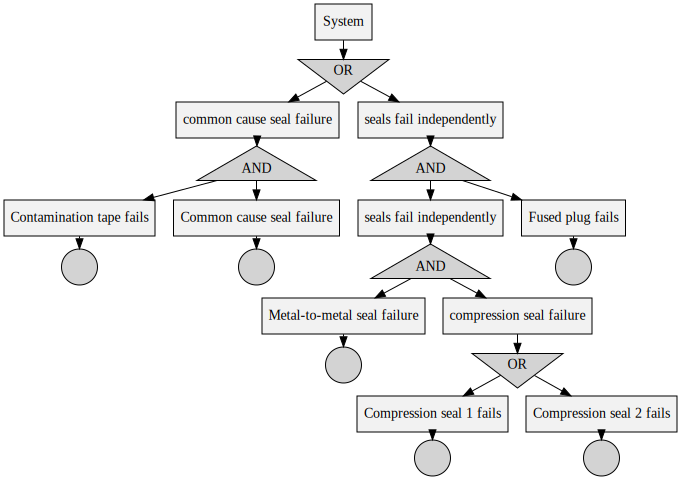

In [5]:
FAULT_TREE.draw()

## Calculating System Unreliabilities 

A standard behaviour is to calculate a system's unreliability based on the Basic Events' (Wires') unreliabilities.

In [6]:
fault_probabilities = {
    contamination_tape_fails: 1.0e-1,
    common_cause_seal_failureBE: 1.0e-5,
    metal_to_metal_seal_fails: 1.0e-3,
    compression_seal_1_fails: 1.0e-3,
    compression_seal_2_fails:1.0e-3,
    fused_plug_fails: 1.0e-3
}

values_df = pd.DataFrame(fault_probabilities.values(), index=fault_probabilities.keys(), columns=["Original Fault Prob."])
display(values_df)

print("System Reliability:", Astrahl(FAULT_TREE, None).calculate_probability(1 - values_df["Original Fault Prob."]))

,Original Fault Prob.
Contamination tape fails,0.10000
Common cause seal failure,0.00001
Metal-to-metal seal failure,0.00100
Compression seal 1 fails,0.00100
Compression seal 2 fails,0.00100
Fused plug fails,0.00100


System Reliability: 0.999799982199918


# Define A Starting Point and Confidence Functions
The goal is to show that Astrahl performs better than other strategies.  

It has a clear advantage when the confidence functions differ, since it uses function gradients to calculate.

Therefore, for our example we set all confidence functions to the same  `1 - .99^(x + 1)`, to show a true comparison of the allowance distribution strategies.


In [7]:
# define the confidence evolution functions
#  1 - (1 - 1/100)^(x + 1),
conf_function = 1 - 0.99 ** (Var() + 1) 

CONF_FUNCTIONS = {
    contamination_tape_fails: conf_function, 
    common_cause_seal_failureBE: conf_function, 
    metal_to_metal_seal_fails: conf_function,
    compression_seal_1_fails: conf_function,
    compression_seal_2_fails: conf_function,
    fused_plug_fails: conf_function,
}

values_df["Starting Point"] = values_df.apply(lambda row: round(random.uniform(0, 200), 2), axis=1)
values_df["Confidence At Start"] = values_df["Starting Point"].apply(lambda x: conf_function(x))
display(values_df)

astrahl = Astrahl(FAULT_TREE, CONF_FUNCTIONS)
print("System Reliability at Starting Point:", astrahl.calculate_probability(1 - values_df["Confidence At Start"]))

,Original Fault Prob.,Starting Point,Confidence At Start
Contamination tape fails,0.10000,190.91,0.854672
Common cause seal failure,0.00001,175.69,0.830651
Metal-to-metal seal failure,0.00100,63.59,0.477511
Compression seal 1 fails,0.00100,50.17,0.402066
Compression seal 2 fails,0.00100,151.23,0.783456
Fused plug fails,0.00100,25.31,0.232352


System Reliability at Starting Point: 0.29259378943587


## Plot the function and starting points

This plot shows the confidence function evolution and the random staring points.  
Note that in our example, all confidence functions are equal, thus there is only one line.

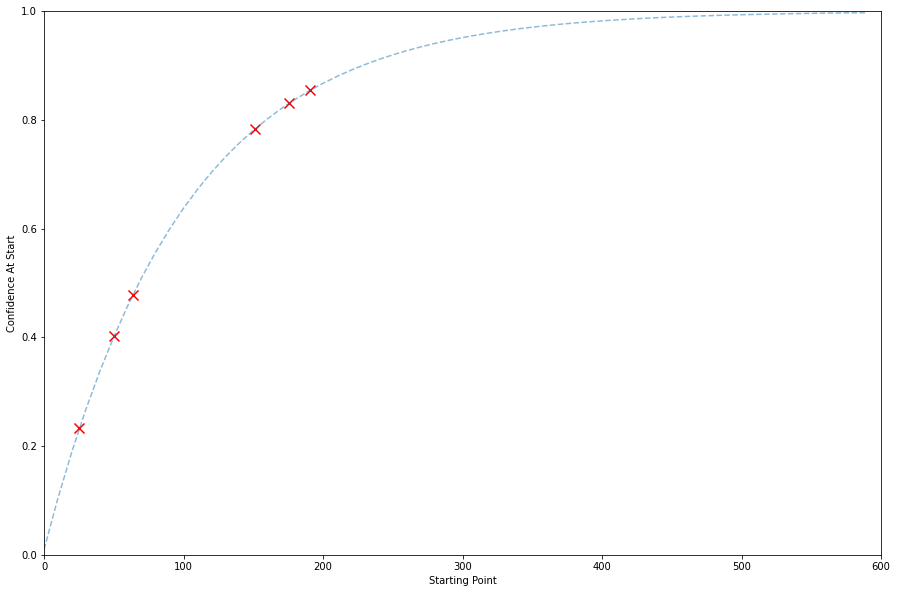

In [8]:
# Plot the starting points as scatter
ax = values_df.plot(x="Starting Point", y="Confidence At Start", kind="scatter", marker="x", color="red", figsize=(15, 10), s=100)

# Plot the evolution of the confidence function
xs = np.arange(0, 600, 10)
ys = [conf_function(x) for x in xs]
ax.plot(xs, ys, ls="--", alpha=0.5, )
ax.set_xlim(0,600); _ = ax.set_ylim(0,1)  # style plot

# Simulated Testing (i.e. spend resources on the the components)

## Naive Attempt: Uniform Distribution

We will have a look at an example where we spend a TEST_BUDGET of 150 among all components.  
This means, every basic event will add 25 to its starting-point value.  
We plot the result (new values are in green) to see what happens.

,Original Fault Prob.,Starting Point,Confidence At Start,Uniform Budget,Uniform End Point,Confidence At End Uniform
Contamination tape fails,0.10000,190.91,0.854672,25.0,215.91,0.886961
Common cause seal failure,0.00001,175.69,0.830651,25.0,200.69,0.868277
Metal-to-metal seal failure,0.00100,63.59,0.477511,25.0,88.59,0.593597
Compression seal 1 fails,0.00100,50.17,0.402066,25.0,75.17,0.534915
Compression seal 2 fails,0.00100,151.23,0.783456,25.0,176.23,0.831568
Fused plug fails,0.00100,25.31,0.232352,25.0,50.31,0.402907


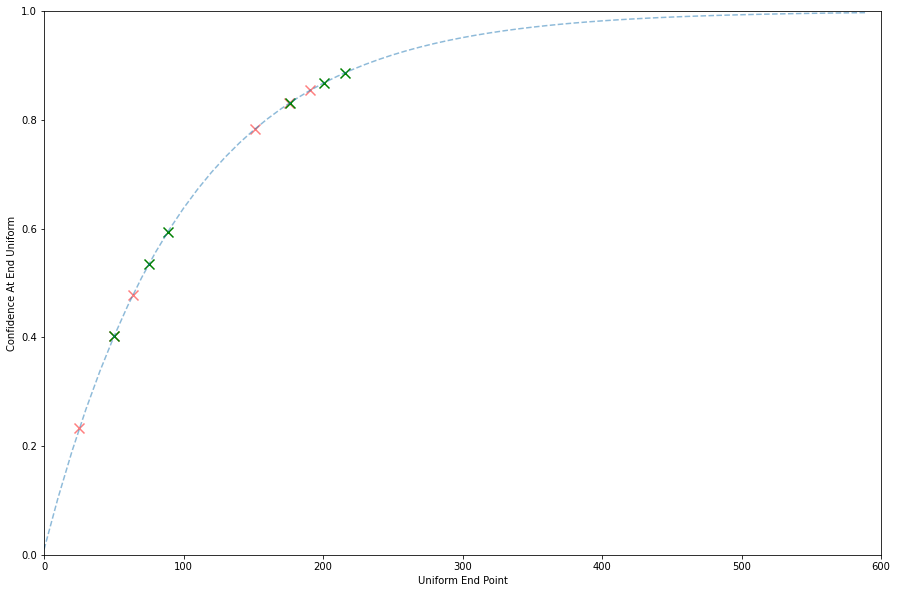

In [9]:
TEST_BUDGET = 150
astrahl = Astrahl(FAULT_TREE, CONF_FUNCTIONS)

# END_POINT = [starting_value + TEST_BUDGET / len(FAULT_TREE.wires) for component, starting_value in STARTING_POINT.items()]
values_df["Uniform Budget"] = TEST_BUDGET / len(FAULT_TREE.wires)
values_df["Uniform End Point"] = values_df["Starting Point"] + values_df["Uniform Budget"]
values_df["Confidence At End Uniform"] = values_df["Uniform End Point"].apply(lambda v: conf_function(v))

display(values_df)

ax = values_df.plot(x="Starting Point", y="Confidence At Start", kind="scatter", marker="x", color="red", figsize=(15, 10), s=100, alpha=0.5)

# for rowidx, row in values_df.iterrows():
#     ax.arrow(row["Starting Point"], row["Confidences At Start"], row["Uniform End Point"] - row["Starting Point"], row["Confidences At Uniform End"] - row["Confidences At Start"], head_width=0.02, head_length=3, length_includes_head=True)
ax = values_df.plot(ax=ax, x="Uniform End Point", y="Confidence At End Uniform", kind="scatter", marker="x", color="Green", figsize=(15, 10), s=100)

ax.plot(xs, ys, ls="--", alpha=0.5,)
ax.set_xlim(0,600); _ = ax.set_ylim(0,1)  # style plot

We can also calculate the system unreliability after the increase.

In [10]:
print("System Unreliability at End Point:", astrahl.calculate_probability(1 - values_df["Confidence At End Uniform"]))

System Unreliability at End Point: 0.147604724534527


# Our Approach
In the next step, we will let Astrahl calculate which amount of resources to spend on each component.

In [11]:
HYPER_PARAMS = {"max_step": 20000, "p_init": 0.0001, "lambda": 35, "function_constant": 0.99}

wire_allowances = astrahl.calculate_allowances(values_df["Starting Point"].to_dict(), total_budget=TEST_BUDGET, algorithm_config=HYPER_PARAMS, cleanup=False)
values_df["Astrahl Budget"] = pd.Series(wire_allowances)
values_df["Astrahl End Point"] = values_df["Starting Point"] + values_df["Astrahl Budget"] # {wire: STARTING_POINT[wire] + allowance for wire, allowance in wire_allowances.items()}
values_df["Confidence at End Astrahl"] = values_df["Astrahl End Point"].apply(lambda v: conf_function(v))
values_df

,Original Fault Prob.,Starting Point,Confidence At Start,Uniform Budget,Uniform End Point,Confidence At End Uniform,Astrahl Budget,Astrahl End Point,Confidence at End Astrahl
Contamination tape fails,0.10000,190.91,0.854672,25.0,215.91,0.886961,0.000327,190.910327,0.854672
Common cause seal failure,0.00001,175.69,0.830651,25.0,200.69,0.868277,0.000297,175.690297,0.830652
Metal-to-metal seal failure,0.00100,63.59,0.477511,25.0,88.59,0.593597,98.357368,161.947368,0.805569
Compression seal 1 fails,0.00100,50.17,0.402066,25.0,75.17,0.534915,0.138386,50.308386,0.402898
Compression seal 2 fails,0.00100,151.23,0.783456,25.0,176.23,0.831568,0.000000,151.230000,0.783456
Fused plug fails,0.00100,25.31,0.232352,25.0,50.31,0.402907,51.503622,76.813622,0.542534


# Compare System Confidence

In [12]:
print("System Reliability at End Point (Uniform):", astrahl.calculate_probability(values_df["Confidence At End Uniform"]))
print("System Reliability at End Point (Astrahl):", astrahl.calculate_probability(values_df["Confidence at End Astrahl"]))

System Reliability at End Point (Uniform): 0.820797942317934
System Reliability at End Point (Astrahl): 0.820315787079281
